## Compare an ensemble of representations from deep nets using ADS and CKA

In [1]:
import torch
import torch.nn as nn
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import os
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import dsutils 
import metrics

import pandas as pd
import random

from sklearn.manifold import MDS
from sklearn.decomposition import PCA


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


### Get the filenames of the sample images

In [2]:
fnames = os.listdir('../imagenet-sample-images/dataset/test/')
fnames.sort()

M = len(fnames)  # number of test samples

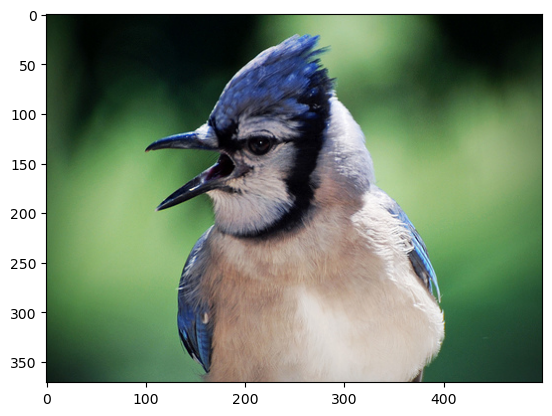

In [3]:
# Show an image

trial_image = fnames[17]
input_image = Image.open('../imagenet-sample-images/dataset/test/'+ trial_image)

plt.imshow(input_image)

### Extract internal representations of some networks
Which internal representation it is is specified in the file extract_internal_reps.py.  This is currently configured to extract the outputs of the penultimate layer in each network.

In [4]:
# Takes a while

import extract_internal_reps

data_dir = '../imagenet-sample-images'

model_names = ["alexnet", "resnet18", "resnet34", "resnet50", "resnet101", "resnet152", "vgg16", "inceptionv3", "squeezenetv1"]
# model_names = ["squeezenetv1"]

internal_reps = []
for model in model_names:
    internal_reps.append(extract_internal_reps.extract_rep(model, data_dir))
    print(model + " done")

Using cpu for inference


Using cache found in /Users/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0


squeezenetv1 done


In [6]:
internal_reps[0].shape

torch.Size([1000, 86528])

### Compute ADS with coarse decoding task

In [14]:
df = pd.read_csv('imagenet_categories_synset.csv')
print(df)
cats = pd.unique(df["categories"])


     index     synset                                              words  \
0        0  n01440764                                 tench, Tinca tinca   
1        1  n01443537                        goldfish, Carassius auratus   
2        2  n01484850  great white shark, white shark, man-eater, man...   
3        3  n01491361                    tiger shark, Galeocerdo cuvieri   
4        4  n01494475                       hammerhead, hammerhead shark   
..     ...        ...                                                ...   
995    995  n13044778                                          earthstar   
996    996  n13052670  hen-of-the-woods, hen of the woods, Polyporus ...   
997    997  n13054560                                             bolete   
998    998  n13133613                              ear, spike, capitulum   
999    999  n15075141       toilet tissue, toilet paper, bathroom tissue   

    categories  
0         fish  
1         fish  
2        shark  
3        shark  
4 

In [15]:
# Make coarse category decoding tasks

z = []
for k in cats[:]:
    zpd = (df["categories"] == k)
    zpd = zpd[0:M]
    zarr = 2*zpd.to_numpy() - 1
    z.append(zarr.reshape(M,1))

In [30]:
ds = metrics.LinearDecodingSimilarity(center_columns=True, a = 0, b = 1)

Cz = dsutils.bespoke_cov_matrix(z)  # Coarse category decoding
# Cz = dsutils.gaussian_partitions_cov_matrix(M,10)  # some random Gaussian tasks
# Cz = np.identity(M)

DSscores = np.zeros((len(internal_reps), len(internal_reps)))

for i in range(len(internal_reps)):
    for j in range(len(internal_reps)):
        DSscores[i,j] = ds.score(internal_reps[i].numpy(),internal_reps[j].numpy(),Cz)


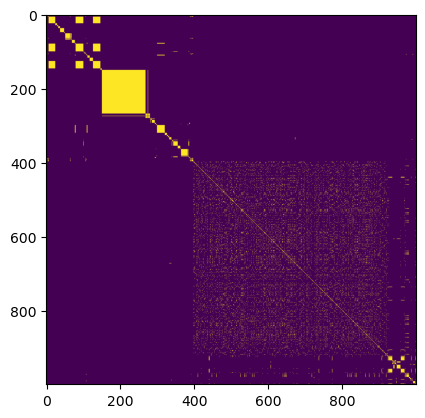

In [32]:
# Look at the covariance matrix

plt.imshow(Cz)

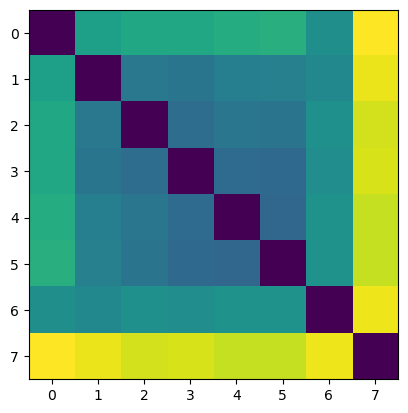

In [33]:
dists_ds = np.arccos(DSscores)
plt.imshow(dists_ds)

### Compute arccos(CKA) between each representation

In [34]:
cka = metrics.LinearCKA(center_columns=True)  # TO DO:  there is some numerical problem with the CKA funtion s.t. it sometimes returns values slightly larger than 1

CKAscores = np.zeros((len(internal_reps), len(internal_reps)))

for i in range(len(internal_reps)):
    for j in range(len(internal_reps)):
        CKAscores[i,j] = cka.score(internal_reps[i].numpy(),internal_reps[j].numpy())


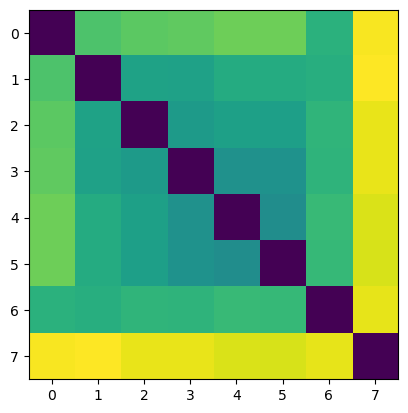

In [35]:
dists_cka = np.arccos(np.round(CKAscores,4))
plt.imshow(dists_cka)

### MDS - PCA plots for visualization

In [36]:
embedding = MDS(n_components=10, metric= True, eps = 0.0001, normalized_stress='auto', dissimilarity='precomputed')
Z = embedding.fit_transform(np.abs(np.real(dists_ds)))
embedding.stress_

np.float64(0.001254715491223303)

In [37]:
pca = PCA(n_components=2)
pcs1 = pca.fit_transform(Z)
np.sum(pca.explained_variance_ratio_)

np.float64(0.7173592682730814)

Text(0.5, 1.0, 'ADS')

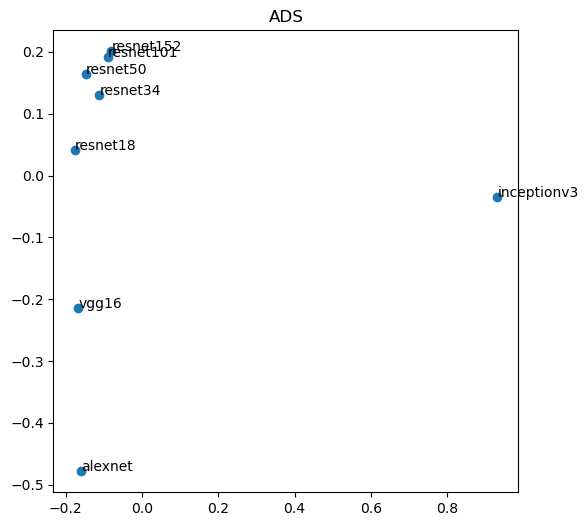

In [38]:
fig = plt.figure(figsize= (6,6))
ax = fig.add_subplot(1,1,1)

ax.scatter(pcs1[:,0], pcs1[:,1])

for i, txt in enumerate(model_names):
    ax.text(pcs1[i,0], pcs1[i,1],txt)

plt.title('ADS')

In [39]:
embedding = MDS(n_components=10, metric= True, eps = 0.0001, normalized_stress='auto', dissimilarity='precomputed')
Z = embedding.fit_transform(np.abs(np.real(dists_cka)))
embedding.stress_

np.float64(0.0013829233658892675)

In [40]:
pca = PCA(n_components=2)
pcs1 = pca.fit_transform(Z)
np.sum(pca.explained_variance_ratio_)

np.float64(0.5805671112628565)

Text(0.5, 1.0, 'CKA')

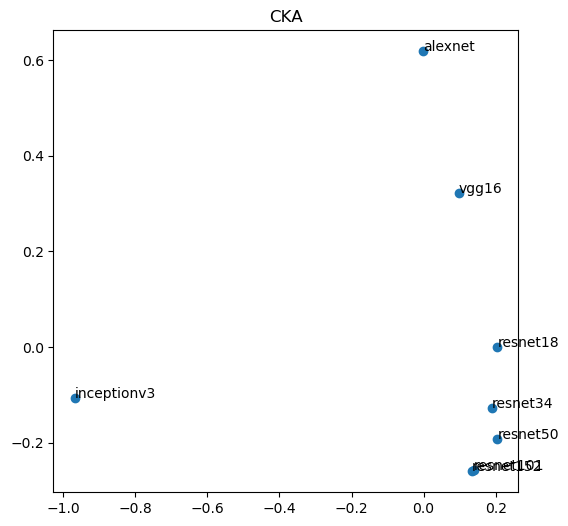

In [41]:
fig = plt.figure(figsize= (6,6))
ax = fig.add_subplot(1,1,1)

ax.scatter(pcs1[:,0], pcs1[:,1])

for i, txt in enumerate(model_names):
    ax.text(pcs1[i,0], pcs1[i,1],txt)

plt.title('CKA')

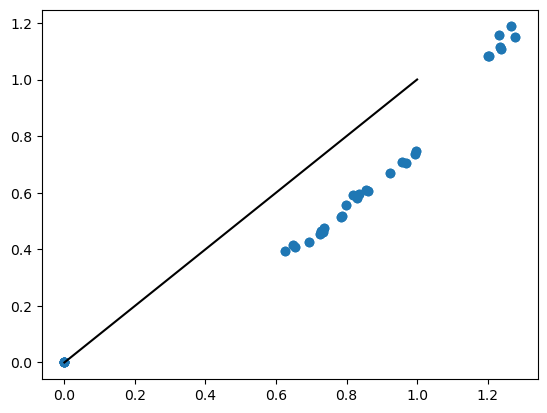

In [42]:
plt.scatter(np.reshape(dists_cka,-1),np.reshape(dists_ds,-1) )
plt.plot([0,1],[0,1],c='black')